In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Reading in data and looking at values - no changes

In [2]:
## Read in training data

movie_training_data = pd.read_csv('train.csv')

movie_training_data.head(3)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000


In [3]:
## Looking at the "belongs to collection" column values. Provides additional data about the collection, which might be useful
## for finding out how sequels impact revenue

movie_training_data.iloc[0,1]

"[{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]"

In [4]:
## Training Data is 3000 records, with 23 columns.

movie_training_data.shape

(3000, 23)

In [5]:
movie_training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [6]:
## Not a lot of correlation between the initial numeric columns

corr_matrix = movie_training_data.corr()

corr_matrix.style.background_gradient(cmap = 'coolwarm')

,id,budget,popularity,runtime,revenue
id,1,0.0197323,-0.00747,0.0107498,0.000609564
budget,0.0197323,1,0.342356,0.238373,0.752965
popularity,-0.00747,0.342356,1,0.13369,0.46146
runtime,0.0107498,0.238373,0.13369,1,0.21638
revenue,0.000609564,0.752965,0.46146,0.21638,1


## Expanding features

#### Looking at film language - heavily skewed to English titles

In [7]:
language_pct_of_revenue = movie_training_data.groupby(['original_language'])['revenue'].sum()
language_pct_of_revenue = language_pct_of_revenue.to_frame().reset_index()

In [8]:
## Calculating total revenue, then figuring out the % of total revenue per language

total_rev = sum(language_pct_of_revenue.revenue)

language_pct_of_revenue['pct_of_total'] = ['%f'%(i/total_rev) for i in language_pct_of_revenue['revenue']]

In [9]:
## Sort values by language - English accounts for 96% of all revenue in our training data

language_pct_of_revenue.sort_values(['pct_of_total'], ascending = False).reset_index(drop = True).head()

,original_language,revenue,pct_of_total
0,en,192264714932,0.960471
1,zh,1337151014,0.006680
2,fr,1336340121,0.006676
3,ja,1134116556,0.005666
4,hi,1064547487,0.005318


#### Exploring cast - the idea that certain actors/actresses bring in revenue

In [10]:
def meta_data_search(regex, column_searched):
    name_search = re.compile(regex)
    return([name_search.findall(str(i)) for i in movie_training_data[column_searched]])

In [11]:
## Sort through the first 3 elements in the "cast_id" column, then append them in order to the first/second/third lists

def cast_clean(df, cast_id_element):
    first_cast = []
    second_cast = []
    third_cast = []

    for row in df.cast_ids:
        if len(row) >= 3:
            first_cast.append(row[cast_id_element])
            second_cast.append(row[cast_id_element + 1])
            third_cast.append(row[cast_id_element + 2])
        elif len(row) == 2:
            first_cast.append(row[cast_id_element])
            second_cast.append(row[cast_id_element + 1])
            third_cast.append(np.NaN)
        elif len(row) == 1:
            first_cast.append(row[cast_id_element])
            second_cast.append(np.NaN)
            third_cast.append(np.NaN)
        else:
            first_cast.append(np.NaN)
            second_cast.append(np.NaN)
            third_cast.append(np.NaN)

    ## Appending new features to our DataFrame
    
    df['first_cast'] = first_cast
    df['second_cast'] = second_cast
    df['third_cast'] = third_cast
    
    return df

In [12]:
def cast_revenue_plots(df, col_name):

    star_revenue = pd.DataFrame(df.groupby(col_name)['revenue']
                                .sum()
                                .sort_values(ascending = False)).reset_index()
    
    plt.figure(figsize = (8, 10))
    plt.barh(col_name, 'revenue', data = star_revenue[0:5])
    plt.title('Revenue by Actor');

In [13]:
## Cast ID's look to be in descending order based on how they are credited

movie_training_data['cast_ids'] = meta_data_search("\'id\'\:\s(\d+)", "cast")

In [14]:
## Find actor/actress names and append them to a list - accounting for full names that contain between 1-4 names
## Backup option in case id# isn't reliable

movie_training_data['cast_names'] = meta_data_search("\'name\'\:\s\'(\w|\w+\s\w+|\w+\s\w+\s\w+|\w+\s\w+\s\w+\s\w+)\'", "cast")

In [15]:
## Sort through the first 3 elements in the "cast_id" column, 
## then append them in order to the first/second/third lists

movie_training_data = cast_clean(movie_training_data, 0)

## Researching the highest revenue first_cast members shows a 3223 ID that isn't associated with any particular name
## Need to remove any cast_id of 3223 from the dataframe as part of a cleanup

cast_id_3223 = movie_training_data[movie_training_data.first_cast == '3223']
movie_training_data = movie_training_data[movie_training_data.first_cast != '3223']

## Sort through the first 3 elements in the "cast_id" column for the 3223 values, 
## then append the updated values in order to the first/second/third lists

cast_id_3223 = cast_clean(cast_id_3223, 1)

## Concat both dataframes

movie_training_data = pd.concat([cast_id_3223, movie_training_data])

In [16]:
## Group data by "first_cast", then sum the revenue and create a DataFrame for plotting

star_revenue = movie_training_data.groupby('first_cast')['revenue'].sum()

star_revenue = star_revenue.sort_values(ascending = False)

star_revenue = pd.DataFrame(star_revenue)

star_revenue = star_revenue.reset_index()

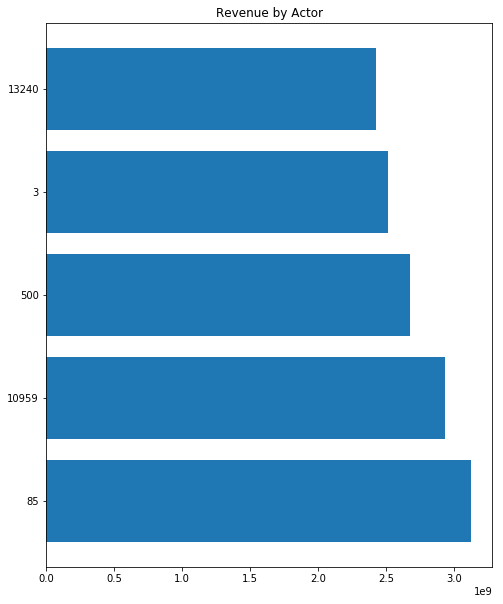

In [17]:
## Showing the top 5 revenue-producing actors from our sample data:

cast_revenue_plots(movie_training_data, 'first_cast')

## Looking at Collections

In [18]:
## Create a binary column to indicate if a title belongs to a collection

movie_training_data['collection_check'] = np.where(pd.isnull(movie_training_data['belongs_to_collection']),0,1)

## Breaking apart and converting release dates

In [19]:
## Split the release date on '/'

new = movie_training_data.release_date.str.split(pat = "/", expand = True)

In [33]:
## Assign each value to a new column, the fill in the 2 first digits of the date based on the year.

movie_training_data['release_month'] = new[0].astype(int)
movie_training_data['release_day'] = new[1].astype(int)
movie_training_data['release_year'] = new[2].astype(int)

release_year = []

## Looping through release_year, adding in the first two digits and padding the year (if between 0-9)
for row in movie_training_data.release_year:
    if row < 20:
        release_year.append(int('20'+str(row).zfill(2)))
    else:
        release_year.append(int('19'+str(row)))
        
movie_training_data['release_year'] = release_year


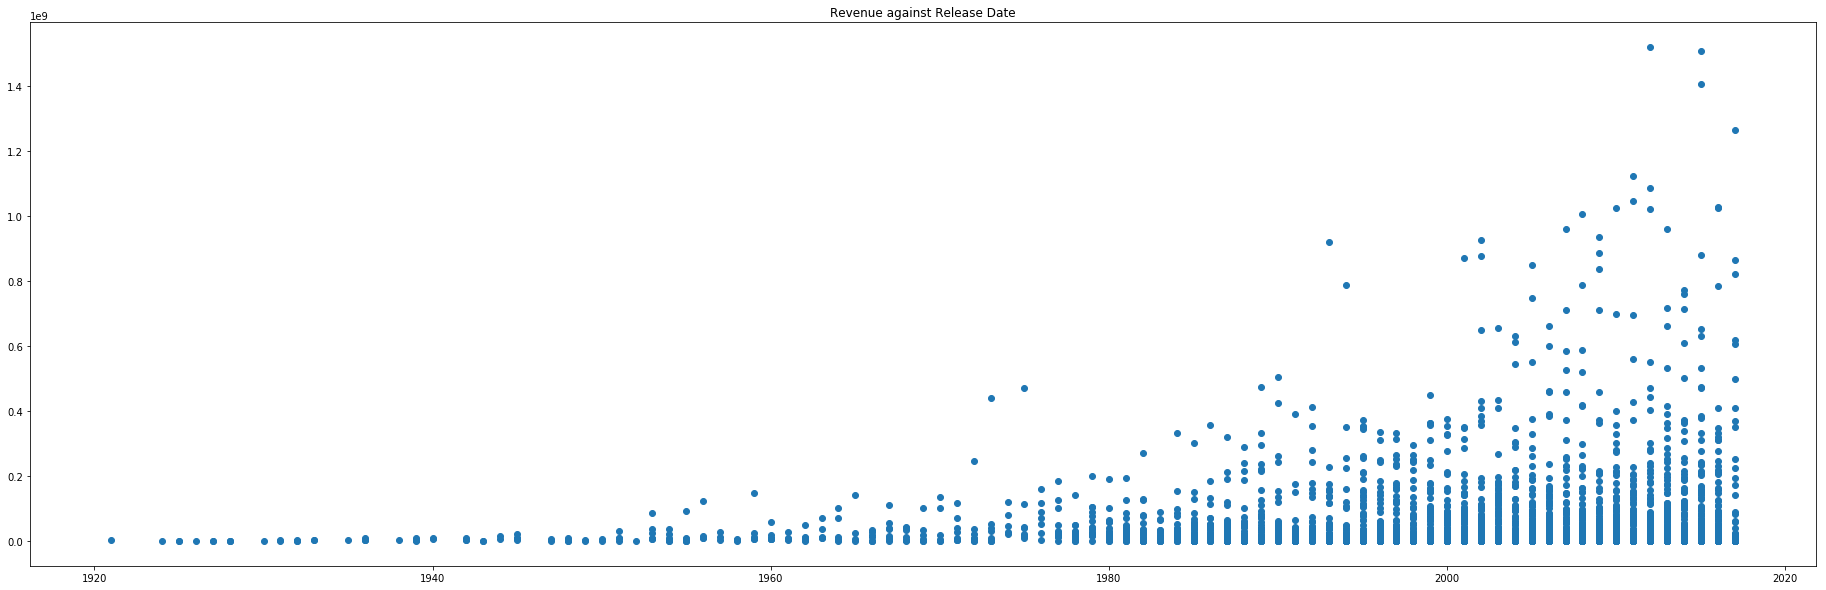

In [34]:
## More movies are produced each year, along with more outliers

plt.figure(figsize = (32, 10))
plt.scatter(movie_training_data.release_year, movie_training_data.revenue, data = movie_training_data)
plt.title('Revenue against Release Date');

## Looking at the budget and revenue columns

In [35]:
## 812 of our initial 3000 rows don't have a value in the budget field

movies_with_budgets = movie_training_data[movie_training_data.budget != 0]

In [36]:
## Checking a correlation between collection_check and revenue

corr_matrix = movies_with_budgets.corr()

corr_matrix.style.background_gradient(cmap = 'coolwarm')

,id,budget,popularity,runtime,revenue,collection_check,release_month,release_day,release_year
id,1,0.0179092,-0.0143253,0.0203996,-0.00266687,-0.00957851,0.0187132,0.00891272,-0.0166877
budget,0.0179092,1,0.310847,0.219426,0.739841,0.220732,0.0178362,0.0300952,0.25075
popularity,-0.0143253,0.310847,1,0.115549,0.444521,0.148274,-0.0215699,0.0376308,0.119172
runtime,0.0203996,0.219426,0.115549,1,0.206727,-0.0651022,0.126389,0.0328006,-0.0384944
revenue,-0.00266687,0.739841,0.444521,0.206727,1,0.351119,0.0130183,0.0483526,0.161176
collection_check,-0.00957851,0.220732,0.148274,-0.0651022,0.351119,1,-0.0528518,-0.00459371,-0.0265725
release_month,0.0187132,0.0178362,-0.0215699,0.126389,0.0130183,-0.0528518,1,-0.00858384,-0.0793078
release_day,0.00891272,0.0300952,0.0376308,0.0328006,0.0483526,-0.00459371,-0.00858384,1,0.0014
release_year,-0.0166877,0.25075,0.119172,-0.0384944,0.161176,-0.0265725,-0.0793078,0.0014,1
